In [11]:
import requests
import pandas as pd
import numpy as np
import joblib
from time import sleep
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
# 1. List of top 20 Indian cities (whitespace fixed)
top_20_cities = [
    "Delhi", "Mumbai", "Bangalore", "Hyderabad", "Ahmedabad",
    "Chennai", "Kolkata", "Pune", "Jaipur", "Lucknow",
    "Kanpur", "Nagpur", "Indore", "Bhopal", "Patna",
    "Vadodara", "Ludhiana", "Agra", "Nashik", "Amritsar"
]

In [13]:
# 2. Date range
start_year = 2015
end_year = 2025

In [14]:
# 3. Function to get lat/lon using Open-Meteo API
def get_coordinates(city):
    url = f"https://geocoding-api.open-meteo.com/v1/search?name={city}&count=1"
    response = requests.get(url)
    data = response.json()
    if "results" in data and data["results"]:
        lat = data["results"][0]["latitude"]
        lon = data["results"][0]["longitude"]
        return lat, lon
    else:
        raise ValueError(f"Could not find coordinates for {city}")

In [15]:
# 4. Function to get NASA POWER data for a given year and city
def fetch_city_data(city, lat, lon, year):
    start_date = f"{year}0101"
    end_date = f"{year}1231"
    parameters = (
        "ALLSKY_SFC_SW_DWN,T2M,RH2M,WS2M,"
        "PRECTOTCORR,PS,CLRSKY_SFC_SW_DWN,ALLSKY_KT"
    )
    base_url = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point?"
        f"parameters={parameters}&start={start_date}&end={end_date}&"
        f"latitude={lat}&longitude={lon}&community=RE&format=JSON"
    )

    response = requests.get(base_url)
    if response.status_code == 200:
        data = response.json()
        if 'properties' in data and 'parameter' in data['properties']:
            params = data['properties']['parameter']
            # Grab the common set of dates from one parameter
            all_dates = list(params['ALLSKY_SFC_SW_DWN'].keys())
            df = pd.DataFrame({'Date': pd.to_datetime(all_dates)})
            # Add each parameter as a column
            for param in params:
                values = [params[param].get(date, np.nan) for date in all_dates]
                df[param] = values
            return df
        else:
            print(f"Malformed data for {city}, {year}")
            return pd.DataFrame()
    else:
        print(f"Failed to fetch data for {city} {year}")
        return pd.DataFrame()

In [16]:
# 5. Training function
def train_model(city, df):
    # Drop rows with missing target
    df = df.dropna(subset=['ALLSKY_SFC_SW_DWN'])
    if df.empty:
        raise ValueError(f"No data with target for city: {city}")
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['Weekday'] = df['Date'].dt.dayofweek

    # Use only non-target features (don't include ALLSKY_SFC_SW_DWN as a regressor input)
    features = [
        'T2M', 'RH2M', 'WS2M', 'PRECTOTCORR', 'PS',
        'CLRSKY_SFC_SW_DWN', 'ALLSKY_KT', 'Month', 'DayOfYear', 'Weekday'
    ]
    available_features = [f for f in features if f in df.columns]
    X = df[available_features].ffill().bfill().fillna(0)
    y = df['ALLSKY_SFC_SW_DWN'].fillna(0)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mean_output = y.mean()

    filename = f"{city.lower().replace(' ', '_')}_xgb_model.pkl"
    joblib.dump(model, filename)

    return {
        "City": city,
        "Mean_Solar_Output": round(mean_output, 2),
        "R2_Score": round(r2, 4),
        "RMSE": round(rmse, 4),
        "Model_File": filename
    }

In [17]:
# 6. Main loop to process all cities
results = []

for city in top_20_cities:
    try:
        print(f"\n🔍 Processing: {city}")
        lat, lon = get_coordinates(city)
        city_data = []

        for year in range(start_year, end_year + 1):
            print(f"📅 Fetching {year}...")
            df_year = fetch_city_data(city, lat, lon, year)
            if not df_year.empty:
                city_data.append(df_year)
            sleep(1)  # Be nice to the API

        if city_data:
            full_df = pd.concat(city_data, ignore_index=True)
            print(f"✅ Data collected for {city}. Rows: {len(full_df)}")

            result = train_model(city, full_df)
            results.append(result)
        else:
            print(f"⚠️ No data collected for {city}")

    except Exception as e:
        print(f"❌ Error with city {city}: {e}")


🔍 Processing: Delhi
📅 Fetching 2015...
📅 Fetching 2016...
📅 Fetching 2017...
📅 Fetching 2018...
📅 Fetching 2019...
📅 Fetching 2020...
📅 Fetching 2021...
📅 Fetching 2022...
📅 Fetching 2023...
📅 Fetching 2024...
📅 Fetching 2025...
✅ Data collected for Delhi. Rows: 3873

🔍 Processing: Mumbai
📅 Fetching 2015...
📅 Fetching 2016...
📅 Fetching 2017...
📅 Fetching 2018...
📅 Fetching 2019...
📅 Fetching 2020...
📅 Fetching 2021...
📅 Fetching 2022...
📅 Fetching 2023...
📅 Fetching 2024...
📅 Fetching 2025...
✅ Data collected for Mumbai. Rows: 3873

🔍 Processing: Bangalore
📅 Fetching 2015...
📅 Fetching 2016...
📅 Fetching 2017...
📅 Fetching 2018...
📅 Fetching 2019...
📅 Fetching 2020...
📅 Fetching 2021...
📅 Fetching 2022...
📅 Fetching 2023...
📅 Fetching 2024...
📅 Fetching 2025...
✅ Data collected for Bangalore. Rows: 3873

🔍 Processing: Hyderabad
📅 Fetching 2015...
📅 Fetching 2016...
📅 Fetching 2017...
📅 Fetching 2018...
📅 Fetching 2019...
📅 Fetching 2020...
📅 Fetching 2021...
📅 Fetching 2022...
📅 Fetc

In [18]:
# 7. Save results summary
summary_df = pd.DataFrame(results)
summary_df.to_csv("solar_city_comparison_summary.csv", index=False)

In [19]:
# 8. Display results
print("\n📊 Solar Radiation Comparison (2015–2025):")
print(summary_df.sort_values(by="Mean_Solar_Output", ascending=False).to_string(index=False))


📊 Solar Radiation Comparison (2015–2025):
     City  Mean_Solar_Output  R2_Score    RMSE              Model_File
Bangalore               4.06    1.0000  0.3254 bangalore_xgb_model.pkl
Ahmedabad               4.06    1.0000  0.3557 ahmedabad_xgb_model.pkl
 Vadodara               3.93    1.0000  0.3330  vadodara_xgb_model.pkl
   Jaipur               3.92    0.9999  0.3821    jaipur_xgb_model.pkl
   Mumbai               3.85    1.0000  0.3506    mumbai_xgb_model.pkl
Hyderabad               3.85    1.0000  0.3342 hyderabad_xgb_model.pkl
  Chennai               3.85    1.0000  0.3457   chennai_xgb_model.pkl
   Indore               3.75    1.0000  0.3515    indore_xgb_model.pkl
   Bhopal               3.74    0.9999  0.3682    bhopal_xgb_model.pkl
   Nashik               3.71    1.0000  0.3386    nashik_xgb_model.pkl
   Nagpur               3.70    0.9999  0.3679    nagpur_xgb_model.pkl
     Pune               3.68    1.0000  0.3370      pune_xgb_model.pkl
 Ludhiana               3.62    1.

/tmp/ipython-input-2404185036.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_sorted, x="City", y="Mean_Solar_Output", palette="viridis")


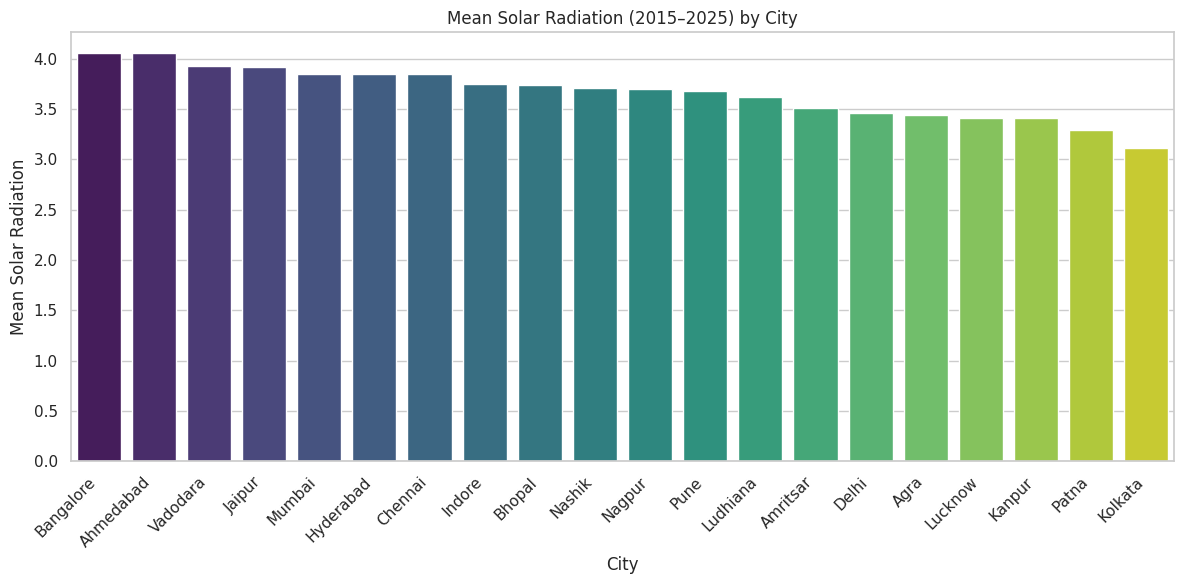

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1. Bar plot: Mean Solar Radiation by City
plt.figure(figsize=(12, 6))
mean_sorted = summary_df.sort_values(by="Mean_Solar_Output", ascending=False)
sns.barplot(data=mean_sorted, x="City", y="Mean_Solar_Output", palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Mean Solar Radiation (2015–2025) by City")
plt.xlabel("City")
plt.ylabel("Mean Solar Radiation")
plt.tight_layout()
plt.show()


